# Proyecto 03
## Visión Por Computadora

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images_dir = 'imagenes/'
input_dir = 'input0'

### 2

In [3]:
def find_homography(image_data_1, image_data_2):
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_data_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_data_2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_2, descriptors_1, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None


### 3

In [4]:
def warping(img1, img2, homography):
    height_img2, width_img2, _ = img2.shape
    height_img1, width_img1, _ = img1.shape
    
    corners_img2 = np.float32([[0, 0], # top-left 
                               [0, height_img2], # bottom-left
                               [width_img2, height_img2], # bottom-right
                               [width_img2, 0]]).reshape(-1,1,2) # top-right
    corners_img2 = cv2.perspectiveTransform(corners_img2, homography)

    [x_min, _] = np.int32(corners_img2.min(axis=0).ravel())
    [x_max, y_max] = np.int32(corners_img2.max(axis=0).ravel())

    x_min = min(0, x_min)
    x_max = max(width_img1, x_max)

    img_warped = cv2.warpPerspective(img2, homography, ((x_max - x_min), max(height_img1, y_max)))
    img_warped[0:height_img1, 0:width_img1] = img1

    return img_warped

IMAGE HEIGHT: 1070
IMAGE HEIGHT: 760


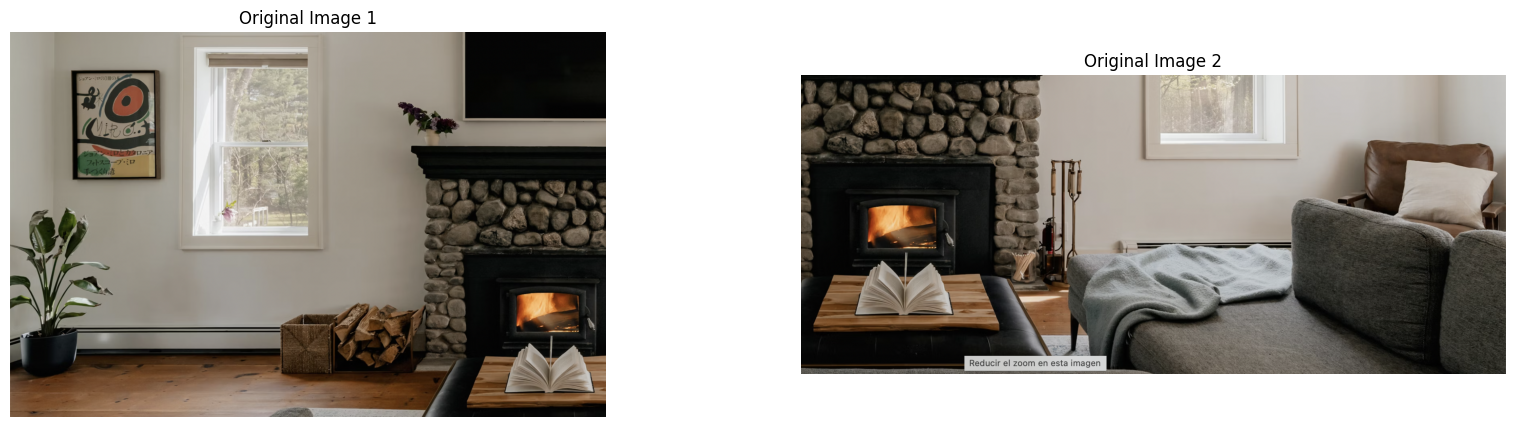

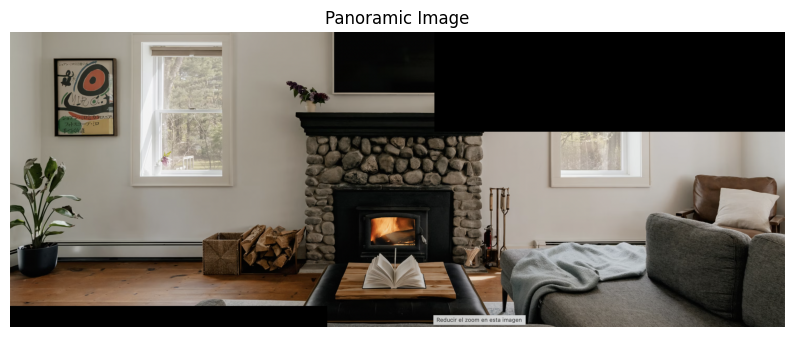

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
images = []
for i in range(2):
    image = cv2.imread(os.path.join(images_dir, input_dir, f's{i+1}.png'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    print(f"IMAGE HEIGHT: {image.shape[0]}")
    images.append(image)

homography_12 = find_homography(images[0], images[1])
warped_img_12 = warping(images[0], images[1], homography_12)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(warped_img_12, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

IMAGE HEIGHT: 214
IMAGE HEIGHT: 210
IMAGE HEIGHT: 216


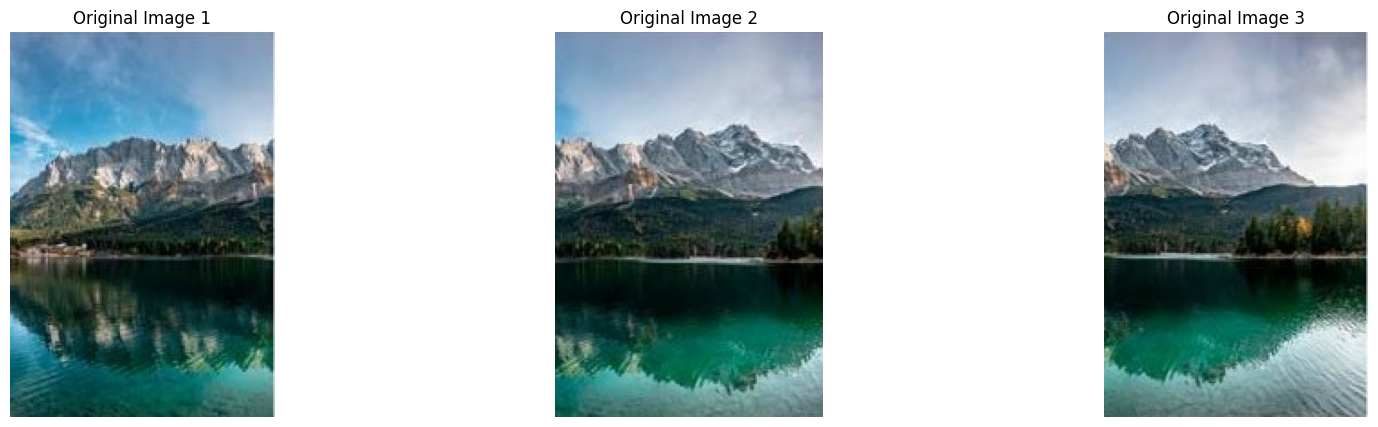

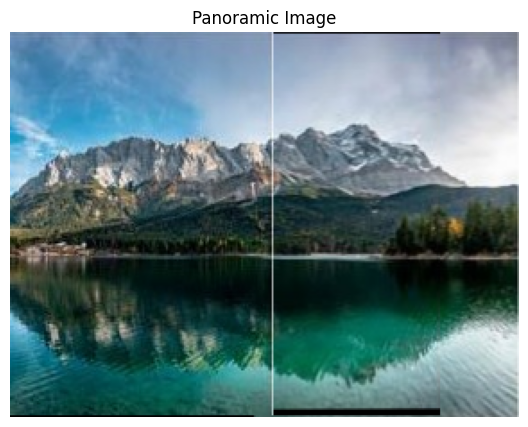

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
images = []
for i in range(3):
    image = cv2.imread(os.path.join(images_dir, input_dir, f'e{i+1}.jpg'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    print(f"IMAGE HEIGHT: {image.shape[0]}")
    images.append(image)

homography_12 = find_homography(images[0], images[1])
homography_23 = find_homography(images[1], images[2])

warped_img_12 = warping(images[0], images[1], homography_12)
final_warped_img = warping(warped_img_12, images[2], np.dot(homography_23, homography_12))

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(final_warped_img, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()